
# Boston House Prices
In this notebook we are going to build a predictive regression model for esitmating the house prices in thousands of $ given some housing factors such as crime rate in neighborhood, number of schools %, lower status of the population etc.

We will apply and elaborate the steps seen in the first Workshop (when applicable).




<dl></dl>
<dl></dl>

**Data Science Cycle:**

    Data Understanding
        0. Exploratory Data Analysis
        
    Data Preparation
        1. Target Definition
        2. Data Splitting
        3. Feature Engineering
    
    Modeling
        4. Variable Selection
        5. Model Selection
        6. Fine-tuning

    Evaluation
        7. Evaluation & Interpretation


# Set Up
Import required libraries

In [1]:
# Boston Data
from sklearn.datasets import load_boston

# Data Manipulation & analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualizations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

# Modeling
from boruta import BorutaPy 
import statsmodels.api as sm 
import sklearn
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
import xgboost as xgb
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.inspection import plot_partial_dependence

# Other Set Up
from datetime import datetime
import os
import warnings
from pprint import pprint

Set styles

In [2]:
# Set style for displaying data
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set style for plotting
sns.set_style("whitegrid")

Fix random seed for reproducibility

In [2]:
np.random.seed(42)

NameError: name 'np' is not defined

# Exploratory Data Analysis

We will start by exploring Boston data (Step 0) and setting the target (Step 1). 

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [5]:
# Read Data
boston = load_boston()

Detailed description of dataset and features

In [6]:
# Print dataset description
print (boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Create pandas dataframe with objects in rows and features in columns, and define target.
In this study, the target is already given as being the housing price (i.e. "MEDV", or the Median value of owner-occupied homes in $1000's)

In [7]:
# Set panda dataframe
boston_data = pd.DataFrame(boston.data)

# Set column names
boston_data.columns = boston.feature_names

# Set target
boston_target=pd.DataFrame(boston.target)
boston_target.columns=['PRICE']

# Merge into 1 data frame
boston_df = pd.merge(boston_data,boston_target,left_index = True, right_index = True)

# Set X and Y (features and target)
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = boston.target

In [8]:
# Check first few rows of data
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# Get descriptive statistics
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Note that some of the features are categorical and some are continious.

**Exploratory Data Analysis Challenge:** Get more feeling about the data!

In [10]:
########################
### INSERT CODE HERE ###
########################

In [11]:
########################
### INSERT CODE HERE ###
########################

In [12]:
########################
### INSERT CODE HERE ###
########################

# Data Preparation

Since this is an academic data set, Data Modeling step is not required and Feature Engineering step is minimal as the data has already been carefully designed and cleaned.

Let's split the data for testing purpose (Data Splitting step). We will set 10% of data aside. 

We can apply normalization to the range of 0 and 1 to make our data insensitive to the scale of features. (Feature Engineering step)

In [13]:
# Create train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

# Scale from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #

# This step is needed so that var selection methods can bring us column names - otherwise, 
# X_Train and Y_train are just numpy arrays, which is efficient for algorithm fitting but not for var selection 
X_train_df=pd.DataFrame(X_train)
X_train_df.columns = boston.feature_names
X_test_df=pd.DataFrame(X_test)
X_test_df.columns = boston.feature_names

(455, 13)
(51, 13)
(455,)
(51,)


There are a lot of features, let's visualize two of them

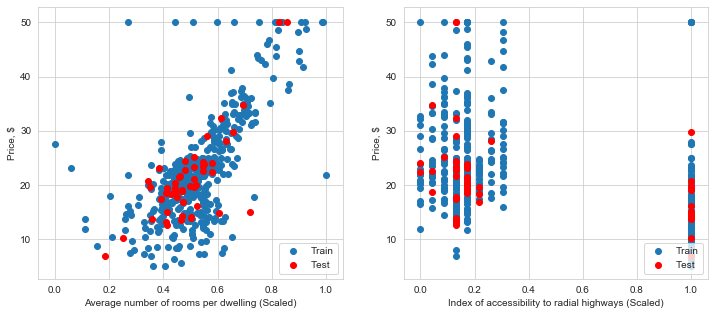

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X_train_df.RM, Y_train, label="Train")
plt.scatter(X_test_df.RM, Y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling (Scaled)")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train_df.RAD, Y_train, label="Train")
plt.scatter(X_test_df.RAD, Y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways (Scaled)")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)

# Modeling

Now our data is ready, we can start modeling steps.

**Variable Selection Challenge:** Try out different methods to decide which features to keep or not

In [16]:
########################
### INSERT CODE HERE ###
########################

In [17]:
########################
### INSERT CODE HERE ###
########################

In [18]:
# Overwrite original df-s with selected variables 
# In the two lines of code below, remove variables to exclude (if any)
X_train = X_train_df[['CRIM', 'NOX', 'INDUS','RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT','ZN','CHAS','RAD']]
X_test = X_test_df[['CRIM', 'NOX', 'INDUS','RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT','ZN','CHAS','RAD']]

We will fit several ML algorithms and compare performance.

In [19]:
# Set model: Simple Linear Regression
LR_model = LinearRegression().fit(X_train,Y_train)

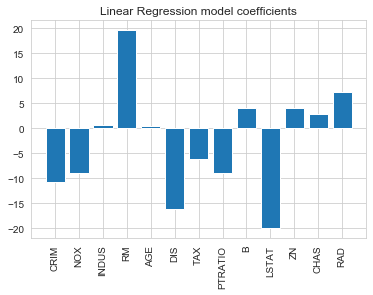

In [20]:
# Visualize Coefficients
sns.set_style("whitegrid")
plt.bar(np.arange(LR_model.coef_.shape[0]), LR_model.coef_)
plt.xticks(np.arange(LR_model.coef_.shape[0]), X_train.columns, rotation='vertical')
plt.xlim([-1, LR_model.coef_.shape[0]])
plt.title("Linear Regression model coefficients")
plt.show()

Predicting both train and test sets to evaluate model

In [21]:
# Predict
preds_test = LR_model.predict(X_test)
preds_train = LR_model.predict(X_train)

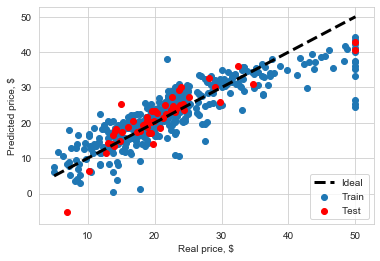

In [22]:
# It also interesting to take a look how the predicted points relate to real ones.
# All the points should lie on the black dotted line assuming that our model is perfect
plt.scatter(Y_train, preds_train, label="Train")
plt.scatter(Y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right", frameon=True)
plt.show()

Let's evaluate our model according to three different metrics:
    - MAE (Mean Absolute Error)
    - RMSE (Root Mean Squared Error)
    - R2 (R Squared)

In [23]:
# Cross-validate model and store scores
LR_score_MAE = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
LR_score_MSE = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
LR_score_R2 = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',LR_score_MAE)

MAE (CV): -3.48


**Variable Selection Challenge:** Try out other models

In [ ]:
##########################
### COMPLETE THE BELOW ###
##########################

# Name of model
_______ = model().fit(X_train, Y_train)

# Cross-validate model and store scores
_____score_MAE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
_____score_MSE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
_____score_R2 = cross_val_score(_______, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',____score_MAE)

In [ ]:
##########################
### COMPLETE THE BELOW ###
##########################

# Name of model
_______ = model().fit(X_train, Y_train)

# Cross-validate model and store scores
_____score_MAE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
_____score_MSE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
_____score_R2 = cross_val_score(_______, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',____score_MAE)

In [ ]:
##########################
### COMPLETE THE BELOW ###
##########################

# Name of model
_______ = model().fit(X_train, Y_train)

# Cross-validate model and store scores
_____score_MAE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
_____score_MSE = cross_val_score(_______, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
_____score_R2 = cross_val_score(_______, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',____score_MAE)

To select the best model, let's compare the performance metrics.

In [ ]:
##########################
### COMPLETE THE BELOW ###
##########################

# Collect all model score results
models = [('__________', ____score_MAE, ____score_MSE, ____score_R2),   
          ('__________', ____score_MAE, ____score_MSE, ____score_R2),   
          ('__________', ____score_MAE, ____score_MSE, ____score_R2),
          ('__________', ____score_MAE, ____score_MSE, ____score_R2), 
          ('__________', ____score_MAE, ____score_MSE, ____score_R2)
         ]

# Gather in a DataFrame
result = pd.DataFrame(data = models, columns=['Model', 'MAE', 'MSE', 'R2'])
result

Random Forest performs well, let's further fine-tune it to see if it can do even better.

In [25]:
# Look at parameters used by our current forest
RF_model = RandomForestRegressor().fit(X_train, Y_train) # fit base model 
print('Parameters currently in use in Random Forest:\n')
pprint(RF_model.get_params())

Parameters currently in use in Random Forest:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


C:\Users\anna.marie.lietar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We will try to fine-tune the following :
    - n_estimators = number of trees in the foreset
    - max_features = max number of features considered for splitting a node
    - max_depth = max number of levels in each decision tree
    - min_samples_split = min number of data points placed in a node before the node is split
    - min_samples_leaf = min number of data points allowed in a leaf node
    - bootstrap = method for sampling data points (with or without replacement)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 4 fold cross validation, 
RF_RS = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 50, cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Fit the random search model
RF_RS_model = RF_RS.fit(X_train, Y_train).best_estimator_

RF_RS_score_MAE = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
RF_RS_score_MSE = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
RF_RS_score_R2 = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',RF_RS_score_MAE)
print(RF_RS_model)

**Fine-Tuning Challenge:** Run random search on XGB as well. Or try another hyper-parameter method!

In [ ]:
########################
### INSERT CODE HERE ###
########################

# Evaluation

Suppose Random Forest performed the best. 
Let's see what variables were the most important

In [ ]:
# Visualising feature importance as per the fine tuned RFR fitting result

##########################
### COMPLETE THE BELOW ###
##########################
# Replace _______ by your random forest model

# Get Feature Importance and sort
col = list(X_test.columns)
sorted(zip(________.feature_importances_,col),reverse=True) 

# Import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create DataFrame
feature_imp = pd.DataFrame(sorted(zip(________.feature_importances_,col)), columns=['Value','Features']) 

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Relative Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Final Evaluation
Y_pred = ________.predict(X_test)
# Check output
print("Prediction:",Y_pred)
print("Actual:",Y_test)

# Calculate Metrics
_____score_MAE_test = mean_absolute_error(Y_test, Y_pred).round(2)
_____score_MSE_test = mean_squared_error(Y_test, Y_pred).round(2)
correlation_matrix = np.corrcoef(Y_test, Y_pred)
______score_r2_test = ((correlation_matrix[0,1])**2).round(2)

# Note that the dataset is tiny and hence testing on an even smaller sample may not be interpretable

print("\n")
print("MAE Test Score:", _____score_MAE_test)
print("MSE Test Score:", ______score_MSE_test)
print("R2 Test Score:", ______score_r2_test)


In [ ]:
# In addition, we can check the Partial Dependence plot of a chosen variable
# check for NOX (the first feature of X gets index [0], and NOX is the second hence "features = [1]")
plot_partial_dependence(estimator = _____, X = X_train, features = [1] ,target='PRICE')